# Phase linking basics

In this notebook, we will walk through the basic theory of phase linking.

We'll create a synthetic stack of SLCs using the [`synth`](https://github.com/opera-adt/synth) library and write the basic functions to perform phase linking.
Then we will run the dolphin workflow on the SLCs files and view the results.

The additional dependences for this notebook (beyond the `dolphin` environment) can be installed with:

```bash
pip install pydantic-settings troposim hdf5plugin matplotlib cmcrameri git+https://github.com/opera-adt/synth.git 
```


## Creating synthetic SLCs

First, let's make the synthetic SLCs using the `synth` library. 

In [54]:
import json
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from dolphin import io, utils

In [2]:
work_dir = Path("./synthetic_slcs")
work_dir.mkdir(exist_ok=True)

os.chdir(work_dir)

In [3]:
synth_json = {
    "output_dir": ".",
    "bounding_box": [-117.9, 34.95, -117.75, 35.05],
    "start_date": "2020-01-01T00:00:00",
    "dt": 12,
    "num_dates": 40,
    "res_y": 15.0,
    "res_x": 15.0,
    "crlb_num_looks": 121,
    "include_turbulence": True,
    "max_turbulence_amplitude": 5.0,
    "include_deformation": True,
    "max_defo_amplitude": 10.0,
    "rho_transform": "shrunk",
    "include_summed_truth": True,
    "multilook_truth": [5, 5],
    "custom_covariance": {
        "gamma_inf": 0.0,
        "tau0": 30.0,
        "gamma0": 1.0,
        "seasonal_A": None,
        "seasonal_B": None,
    },
}
with open("synth-config.json", "w") as f:
    f.write(json.dumps(synth_json))

In [4]:
from synth.config import SimulationInputs
from synth.core import create_simulation_data

with open("synth-config.json") as f:
    inputs = SimulationInputs.model_validate_json(f.read())
    create_simulation_data(inputs)

2025-05-22 14:45:54,998 - synth - INFO - profile={'height': 740, 'width': 913, 'count': 1, 'compress': 'lzw', 'transform': [0.00016429353778751993, 0.0, -117.9, 0.0, -0.00013513513513512747, 35.05, 0.0, 0.0, 1.0], 'crs': 'EPSG:4326', 'driver': 'GTiff', 'dtype': 'complex64', 'interleave': 'band', 'nodata': 0.0, 'tiled': True, 'blockxsize': 256, 'blockysize': 256}
2025-05-22 14:45:54,999 - synth - INFO - shape3d = (40, 740, 913)
2025-05-22 14:45:54,999 - synth - INFO - Generating turbulence


  0%|          | 0/40 [00:00<?, ?it/s]

2025-05-22 14:45:58,902 - synth - INFO - Generating deformation


  0%|          | 0/40 [00:00<?, ?it/s]

2025-05-22 14:46:00,870 - synth - INFO - Generating ramps
2025-05-22 14:46:03,914 - synth - INFO - Simulating correlated noise


  0%|          | 0/48 [00:00<?, ?it/s]

In [11]:
!ls
!ls input_layers
!ls slcs | head -5

crlb_std_devs.csv input_layers      slcs              synth-config.json
deformation.h5        truth_unwrapped_diffs
phase_ramps.h5        turbulence.h5
20200101.slc.tif
20200113.slc.tif
20200125.slc.tif
20200206.slc.tif
20200218.slc.tif


## Inspect the simulated data

Let's make some interferograms to see what the data looks like.
We'll form interferograms by performing a boxcar averaging with (11, 11) looks.

In [76]:
slc_file_list = sorted(Path("slcs").glob("2*.tif"))

# Create a Reader for the SLC stack
reader = io.RasterStackReader.from_file_list(slc_file_list)
print(reader.shape)

(40, 740, 913)

In [72]:
def make_ifg(idx1: int, idx2: int, looks: tuple[int, int] = (11, 11)) -> np.ndarray:
    """Create an interferogram between slcs idx1 and idx1."""
    # Load complex images
    s1 = np.squeeze(reader[idx1, :, :].filled(0))
    s2 = np.squeeze(reader[idx2, :, :].filled(0))
    # Raw interferogram
    raw_ifg = s1 * np.conj(s2)
    # Apply looks to interferogram and power
    ifg = utils.take_looks(raw_ifg, *looks)
    pow1 = utils.take_looks(s1 * np.conj(s1), *looks)
    pow2 = utils.take_looks(s2 * np.conj(s2), *looks)
    # Normalize by coherence
    ifg = ifg / np.sqrt(pow1 * pow2)
    return ifg

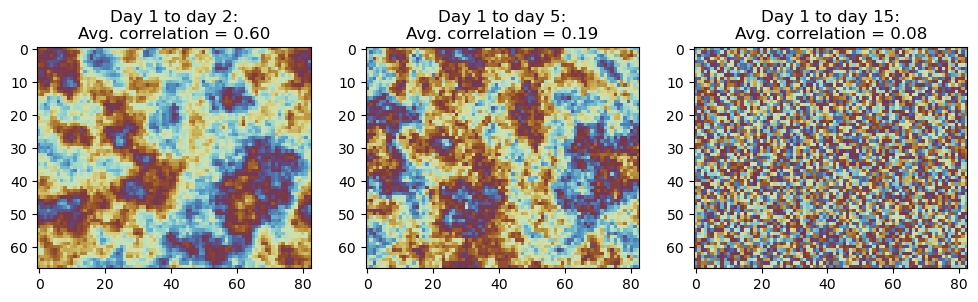

In [75]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 6))
kw = {"vmin": -np.pi, "vmax": np.pi, "cmap": "cmc.romaO", "interpolation": "nearest"}

for ax, n in zip(axes, [1, 4, 14]):
    ifg_0_n = make_ifg(0, n)
    title = f"Day 1 to day {n+1}:\n"
    title += "Avg. correlation = {np.nanmedian(np.abs(ifg_0_n)):.2f}"
    ax.imshow(np.angle(ifg_0_n), **kw)
    ax.set_title(title)

So after just 15 images, the normal multilooked interferograms look completely decorrelated (note that very low correlations will always be skewed upwards).

## Phase linking in X lines of python

Here we will write out the simplest form of phase linking in Python in as few lines as possible:

### 1. Read in a block of SLC pixels

Get SLC samples into an array of shape (`nslc`, `num_samples`). 
The `num_samples` is the "number of looks" we perform when making all possible multilooked interferograms.

In [18]:
nslc = reader.shape[0]
half_row, half_col = (5, 5)

# Pick a row and column to process
row, col = 100, 100
sub_stack = reader[
    :, row - half_row : row + half_row + 1, col - half_col : col + half_col + 1
].filled(0)
slc_samples = sub_stack.reshape(nslc, -1)
print(sub_stack.shape, slc_samples.shape)

(40, 11, 11)
(40, 121)

### 2. Form the coherence matrix, $T \in \mathbb{C}^{N\times N}$ of all possible interferogrms.

The $m,n$ th element of this matrix is $\rho_{m,n}\exp (j \cdot \phi_{m,n})$, where $\rho_{m,n}$ correlation magnitude of the interferogram between image $m$ and image $n$, and $\phi_{m,n}$ is the interferometric phase.

In [82]:
# Compute un-normalized interferogram, the numerator of the complex correlation formula
ifgs = np.dot(slc_samples, np.conj(slc_samples.T))

# Compute amplitudes so we normalize the covariance to a coherence matrix
# amp_vec is shape (nslc,)
amp_vec = np.sum(np.abs(slc_samples) ** 2, axis=1)

# Form outer product of amplitudes for each slc to get an (N, N) power matrix
powers = amp_vec[:, None] * amp_vec[None, :]
amplitudes = np.sqrt(powers)

# Compute coherence matrix
coherence = ifgs / amplitudes

# recommended: Make the output 0 where the amplitudes are 0,
# rather than dividing by zero, like
# coherence = np.where(amplitudes > 1e-6, coherence, 0 + 0j)

In [21]:
print(coherence.shape, coherence.dtype)

(40, 40)
complex64

Let's plot the coherence matrix for this pixel:

Text(0.5, 1.0, 'Phase')

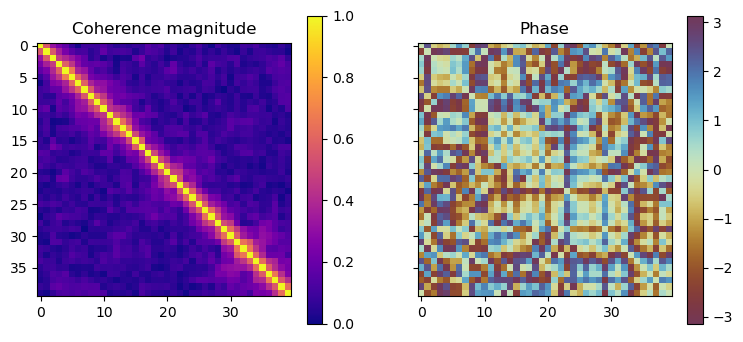

In [53]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharex=True, sharey=True)
axim = axes[0].imshow(np.abs(coherence), vmax=1, vmin=0, cmap="plasma")
fig.colorbar(axim, ax=axes[0])
axim = axes[1].imshow(np.angle(coherence), cmap="cmc.romaO")
fig.colorbar(axim, ax=axes[1])

axes[0].set_title("Coherence magnitude")
axes[1].set_title("Phase")

### 3. Optimize the coherence matrix to get a phase vector

There are many "coherence optimization algorithms" [@Ansari2018EfficientPhaseEstimation].

Here we pick the simplest to implement: "EVD", also known as "CAESAR" in [@Fornaro2015CAESARApproachBased]

The idea is the same as [principle component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis): we take the largest eigenvector.

(That is, compute the eigenvectors and eigenvalues of the coherence matrix, then use the eigenvector corresponding the largest eigenvalue)

In [78]:
from scipy.linalg import eigh  # Hermitian eigenvalue function from scipy


def largest_eigenpair(T):
    """Get the largest eigenvalue for the "EVD/ CAESAR" method."""
    lambda_, eig_vecs = eigh(T)
    return lambda_[-1], eig_vecs[:, -1]


In [84]:
lambda_, V = largest_eigenpair(coherence)
print(V.shape)

(40,)

One note: Since we are working with "phase differences", there is an argibrarty phase offset in the solution vector. 
So, we must pick some index and use that as the "reference". 

In [83]:
# reference the phases to one of the elements to remove the arbitrary offset
V *= V[0].conj()

After running this on every pixel, the result will be a set of single-reference interferograms.

But, this manual way will be slow, so we'll do the same thing in Dolphin.

## Running Dolphin on the SLC stack

In [80]:
from dolphin.workflows import DisplacementWorkflow, displacement

cfg = DisplacementWorkflow(
    # Only required input: the list of SLC files
    cslc_file_list=slc_file_list,
    # We'll make the output subsampled by 5x5 to run faster, and come out with the same
    # size images at the `take_looks` version
    strides={"x": 5, "y": 5},

    phase_linking={
        # Also use 121 looks
        "half_window": {"x": 5, "y": 5},
        # Use the EVD algorithm like we did above
        "use_evd": True
    },
    # Skip unwrapping just to look at interferograms
    unwrap_options={"run_unwrap": False},
    work_directory=Path("dolphin"),
)

In [27]:
displacement.run(cfg);

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
[INFO|displacement|L100] 2025-05-22T14:55:14-0400: Found SLC files from 1 bursts
[INFO|wrapped_phase|L68] 2025-05-22T14:55:14-0400: Running wrapped phase estimation in /Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking
[WARNING|wrapped_phase|L506] 2025-05-22T14:55:14-0400: Could not make nodata mask: /Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/slcs/20210413.slc.tif is not a CSLC file
[INFO|wrapped_phase|L112] 2025-05-22T14:55:14-0400: Creating persistent scatterer file /Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking/PS/ps_pixels.tif
[INFO|_readers|L1088] 2025-05-22T14:55:14-0400: Processing (512, 512) sized blocks...


PS (/Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking/PS):   0%|          | 0/…

[INFO|ps|L159] 2025-05-22T14:55:16-0400: Waiting to write 0 blocks of data.
[INFO|ps|L162] 2025-05-22T14:55:16-0400: Repacking PS rasters for better compression
[INFO|ps|L166] 2025-05-22T14:55:16-0400: Finished writing out PS files
[INFO|ps|L299] 2025-05-22T14:55:16-0400: No striding request, skipping multilook.
[INFO|wrapped_phase|L168] 2025-05-22T14:55:16-0400: Running sequential EMI step in /Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking/linked_phase
[INFO|sequential|L82] 2025-05-22T14:55:16-0400: File range start: 20200101.slc.tif
[INFO|sequential|L83] 2025-05-22T14:55:16-0400: File range end: 20210413.slc.tif
[INFO|sequential|L84] 2025-05-22T14:55:16-0400: Output folder: /Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking/linked_phase
[INFO|sequential|L85] 2025-05-22T14:55:16-0400: Number of ministacks of size 15: 3
[INFO|sequential|L110] 2025-05-22T14:55:16-0400: Processing 15 SLCs. Output folder: /Users/staniewi/rep

Phase linking (/Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking/linked_phase)…

[INFO|single|L330] 2025-05-22T14:55:36-0400: Waiting to write 19 blocks of data.
[INFO|single|L332] 2025-05-22T14:55:36-0400: Finished ministack of size (15, 740, 913).
[INFO|single|L335] 2025-05-22T14:55:36-0400: Repacking for more compression


Processing Rasters:   0%|          | 0/15 [00:00<?, ?it/s]

[INFO|single|L338] 2025-05-22T14:55:37-0400: Creating similarity raster on outputs


  0%|          | 0/4 [00:00<?, ?it/s]

[INFO|sequential|L110] 2025-05-22T14:55:44-0400: Processing 16 SLCs. Output folder: /Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking/linked_phase/20200629_20201214
[INFO|single|L85] 2025-05-22T14:55:44-0400: VRTStack(16 bands, outfile=/Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking/linked_phase/20200629_20201214.vrt): from (datetime.datetime(2020, 1, 1, 0, 0), datetime.datetime(2020, 1, 1, 0, 0), datetime.datetime(2020, 6, 17, 0, 0)) to [datetime.datetime(2020, 12, 14, 0, 0)]
[INFO|single|L104] 2025-05-22T14:55:44-0400: Processing 15 SLCs + 1 compressed SLCs. 
[INFO|single|L109] 2025-05-22T14:55:44-0400: Total stack size (in pixels): (16, 740, 913)


Phase linking (/Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking/linked_phase)…

[INFO|single|L330] 2025-05-22T14:56:01-0400: Waiting to write 19 blocks of data.
[INFO|single|L332] 2025-05-22T14:56:01-0400: Finished ministack of size (16, 740, 913).
[INFO|single|L335] 2025-05-22T14:56:02-0400: Repacking for more compression


Processing Rasters:   0%|          | 0/15 [00:00<?, ?it/s]

[INFO|single|L338] 2025-05-22T14:56:02-0400: Creating similarity raster on outputs


  0%|          | 0/4 [00:00<?, ?it/s]

[INFO|sequential|L110] 2025-05-22T14:56:08-0400: Processing 12 SLCs. Output folder: /Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking/linked_phase/20201226_20210413
[INFO|single|L85] 2025-05-22T14:56:08-0400: VRTStack(12 bands, outfile=/Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking/linked_phase/20201226_20210413.vrt): from (datetime.datetime(2020, 1, 1, 0, 0), datetime.datetime(2020, 1, 1, 0, 0), datetime.datetime(2020, 6, 17, 0, 0)) to [datetime.datetime(2021, 4, 13, 0, 0)]
[INFO|single|L104] 2025-05-22T14:56:08-0400: Processing 10 SLCs + 2 compressed SLCs. 
[INFO|single|L109] 2025-05-22T14:56:08-0400: Total stack size (in pixels): (12, 740, 913)


Phase linking (/Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking/linked_phase)…

[INFO|single|L330] 2025-05-22T14:56:16-0400: Waiting to write 14 blocks of data.
[INFO|single|L332] 2025-05-22T14:56:16-0400: Finished ministack of size (12, 740, 913).
[INFO|single|L335] 2025-05-22T14:56:16-0400: Repacking for more compression


Processing Rasters:   0%|          | 0/10 [00:00<?, ?it/s]

[INFO|single|L338] 2025-05-22T14:56:17-0400: Creating similarity raster on outputs


  0%|          | 0/4 [00:00<?, ?it/s]

[INFO|sequential|L233] 2025-05-22T14:56:22-0400: Averaging 3 files into /Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking/linked_phase/temporal_coherence_average_20200101_20210413.tif
[INFO|sequential|L233] 2025-05-22T14:56:22-0400: Averaging 3 files into /Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking/linked_phase/shp_counts_average_20200101_20210413.tif


  0%|          | 0/4 [00:00<?, ?it/s]

[INFO|wrapped_phase|L215] 2025-05-22T14:56:25-0400: wrapped_phase complete
[INFO|wrapped_phase|L241] 2025-05-22T14:56:25-0400: Creating virtual interferograms from 40 files
[INFO|_log|L102] 2025-05-22T14:56:25-0400: Total elapsed time for dolphin.workflows.wrapped_phase.run : 1.18 minutes (71.08 seconds)
[INFO|stitching_bursts|L107] 2025-05-22T14:56:25-0400: Stitching interferograms by date.
[INFO|stitching|L95] 2025-05-22T14:56:25-0400: (datetime.datetime(2020, 1, 1, 0, 0), datetime.datetime(2020, 1, 13, 0, 0)): Stitching 1 images.
[INFO|stitching|L95] 2025-05-22T14:56:25-0400: (datetime.datetime(2020, 1, 1, 0, 0), datetime.datetime(2020, 1, 25, 0, 0)): Stitching 1 images.
[INFO|stitching|L95] 2025-05-22T14:56:25-0400: (datetime.datetime(2020, 1, 1, 0, 0), datetime.datetime(2020, 2, 6, 0, 0)): Stitching 1 images.
[INFO|stitching|L95] 2025-05-22T14:56:25-0400: (datetime.datetime(2020, 1, 1, 0, 0), datetime.datetime(2020, 2, 18, 0, 0)): Stitching 1 images.
[INFO|stitching|L95] 2025-05-2

Merging images by date:   0%|          | 0/39 [00:00<?, ?it/s]

[INFO|stitching|L204] 2025-05-22T14:56:25-0400: Only one image, no stitching needed
[INFO|stitching|L205] 2025-05-22T14:56:25-0400: Copying /Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking/interferograms/20200101_20200125.int.vrt to /Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/interferograms/20200101_20200125.int.tif and zeroing nodata values.
[INFO|stitching|L205] 2025-05-22T14:56:25-0400: Copying /Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking/interferograms/20200101_20200113.int.vrt to /Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/interferograms/20200101_20200113.int.tif and zeroing nodata values.
[INFO|stitching|L205] 2025-05-22T14:56:25-0400: Copying /Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking/interferograms/20200101_20200206.int.vrt to /Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/interferograms/20200101_202002

Estimating correlations:   0%|          | 0/39 [00:00<?, ?it/s]

[INFO|stitching|L204] 2025-05-22T14:56:29-0400: Only one image, no stitching needed
[INFO|stitching|L205] 2025-05-22T14:56:29-0400: Copying /Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking/linked_phase/temporal_coherence_average_20200101_20210413.tif to /Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/interferograms/temporal_coherence.tif and zeroing nodata values.
[INFO|stitching|L204] 2025-05-22T14:56:29-0400: Only one image, no stitching needed
[INFO|stitching|L205] 2025-05-22T14:56:29-0400: Copying /Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking/PS/ps_pixels.tif to /Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/interferograms/ps_mask_looked.tif and zeroing nodata values.
[INFO|stitching|L204] 2025-05-22T14:56:29-0400: Only one image, no stitching needed
[INFO|stitching|L205] 2025-05-22T14:56:29-0400: Copying /Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/p

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[INFO|_log|L102] 2025-05-22T14:56:29-0400: Total elapsed time for dolphin.workflows.stitching_bursts.run : 0.07 minutes (4.42 seconds)
[INFO|displacement|L202] 2025-05-22T14:56:29-0400: Skipping unwrap step
[INFO|displacement|L294] 2025-05-22T14:56:29-0400: Maximum memory usage: 11.35 GB
[INFO|displacement|L295] 2025-05-22T14:56:29-0400: Config file dolphin version: 0.38.0.post1.dev7+g93ef0fe.d20250424
[INFO|displacement|L296] 2025-05-22T14:56:29-0400: Current running dolphin version: 0.38.0.post1.dev7+g93ef0fe.d20250424
[INFO|_log|L102] 2025-05-22T14:56:29-0400: Total elapsed time for dolphin.workflows.displacement.run : 1.26 minutes (75.56 seconds)


OutputPaths(comp_slc_dict={'phase_linking': [PosixPath('/Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking/linked_phase/compressed_20200101_20200101_20200617.tif'), PosixPath('/Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking/linked_phase/compressed_20200101_20200629_20201214.tif'), PosixPath('/Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/phase_linking/linked_phase/compressed_20200101_20201226_20210413.tif')]}, stitched_ifg_paths=[PosixPath('/Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/interferograms/20200101_20200113.int.tif'), PosixPath('/Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/interferograms/20200101_20200125.int.tif'), PosixPath('/Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/interferograms/20200101_20200206.int.tif'), PosixPath('/Users/staniewi/repos/dolphin/docs/notebooks/synthetic_slcs/dolphin/interferograms/20200101_20200218

### Inspect the outputs

In [29]:
!ls dolphin

dolphin.log    interferograms phase_linking


In [32]:
!ls dolphin/phase_linking/linked_phase

!ls dolphin/interferograms | head

20200101_20200617
20200101_20200617.vrt
20200101.slc.tif
20200113.slc.tif
20200125.slc.tif
20200206.slc.tif
20200218.slc.tif
20200301.slc.tif
20200313.slc.tif
20200325.slc.tif
20200406.slc.tif
20200418.slc.tif
20200430.slc.tif
20200512.slc.tif
20200524.slc.tif
20200605.slc.tif
20200617.slc.tif
20200629_20201214
20200629_20201214.vrt
20200629.slc.tif
20200711.slc.tif
20200723.slc.tif
20200804.slc.tif
20200816.slc.tif
20200828.slc.tif
20200909.slc.tif
20200921.slc.tif
20201003.slc.tif
20201015.slc.tif
20201027.slc.tif
20201108.slc.tif
20201120.slc.tif
20201202.slc.tif
20201214.slc.tif
20201226_20210413
20201226_20210413.vrt
20201226.slc.tif
20210107.slc.tif
20210119.slc.tif
20210131.slc.tif
20210212.slc.tif
20210224.slc.tif
20210308.slc.tif
20210320.slc.tif
20210401.slc.tif
20210413.slc.tif
compressed_20200101_20200101_20200617.tif
compressed_20200101_20200629_20201214.tif
compressed_20200101_20201226_20210413.tif
shp_counts_average_20200101_20210413.tif
sim_inputs.vrt
similarity_full_20

In [33]:
!ls dolphin/phase_linking/linked_phase/20200101_20200617

avg_coh_20200101_20200617.tif
eigenvalues_20200101_20200617.tif
estimator_20200101_20200617.tif
shp_counts_20200101_20200617.tif
sim_inputs.vrt
similarity_20200101_20200617.tif
temporal_coherence_20200101_20200617.tif


### Plot the temporal coherences of each ministackm


In [37]:
temp_coh_files = sorted(Path("dolphin/phase_linking/").rglob("temporal_coherence_20*"))
print(temp_coh_files)

[
    PosixPath('dolphin/phase_linking/linked_phase/20200101_20200617/temporal_coherence_20200101_20200617.tif'),
    PosixPath('dolphin/phase_linking/linked_phase/20200629_20201214/temporal_coherence_20200629_20201214.tif'),
    PosixPath('dolphin/phase_linking/linked_phase/20201226_20210413/temporal_coherence_20201226_20210413.tif')
]

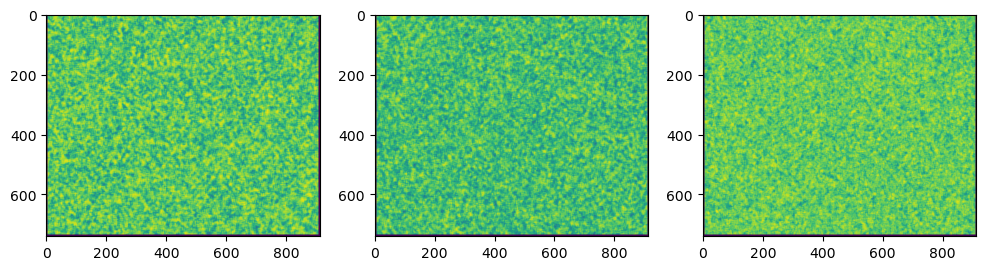

In [38]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
for ax, fname in zip(axes, temp_coh_files):
    ax.imshow(io.load_gdal(fname), cmap='viridis', vmax=1, vmin=0)

It's pretty non-descript, since we did the same simulated decorrelation at each pixel.
But, one thing to note is that the final stack: there is a higher temporal coherence.

This is an artifact from running phase linking on a stack with *fewer images* (there were 10 SLCs left over after running ministack sizes of 15 on the 40 inputs).
So it's important to note that the temporal coherence is only meaningful *relative to the size of the SLC stack*.

Let's also check the phase cosine similarity rasters:

In [39]:
sim_files = sorted(Path("dolphin/phase_linking/").rglob("similarity_20*"))
print(sim_files)

[
    PosixPath('dolphin/phase_linking/linked_phase/20200101_20200617/similarity_20200101_20200617.tif'),
    PosixPath('dolphin/phase_linking/linked_phase/20200629_20201214/similarity_20200629_20201214.tif'),
    PosixPath('dolphin/phase_linking/linked_phase/20201226_20210413/similarity_20201226_20210413.tif')
]

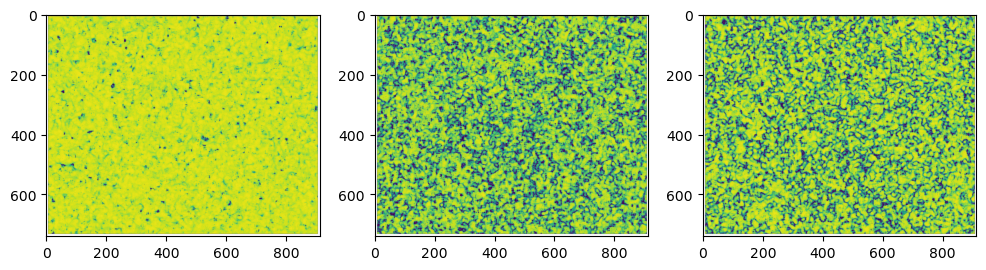

In [40]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
for ax, fname in zip(axes, sim_files):
    ax.imshow(io.load_gdal(fname), cmap='viridis', vmax=1, vmin=0)

Here we see a slight drop in cosine similarity after the first ministack: this is result of the longer-baseline interfeorgrams coming from the compressed SLC.


Finally the interferogram phases:

In [43]:
ifg_files = sorted(Path("dolphin/interferograms/").rglob("2*.int.tif"))
print(ifg_files[:4], len(ifg_files))

[
    PosixPath('dolphin/interferograms/20200101_20200113.int.tif'),
    PosixPath('dolphin/interferograms/20200101_20200125.int.tif'),
    PosixPath('dolphin/interferograms/20200101_20200206.int.tif'),
    PosixPath('dolphin/interferograms/20200101_20200218.int.tif')
]
39

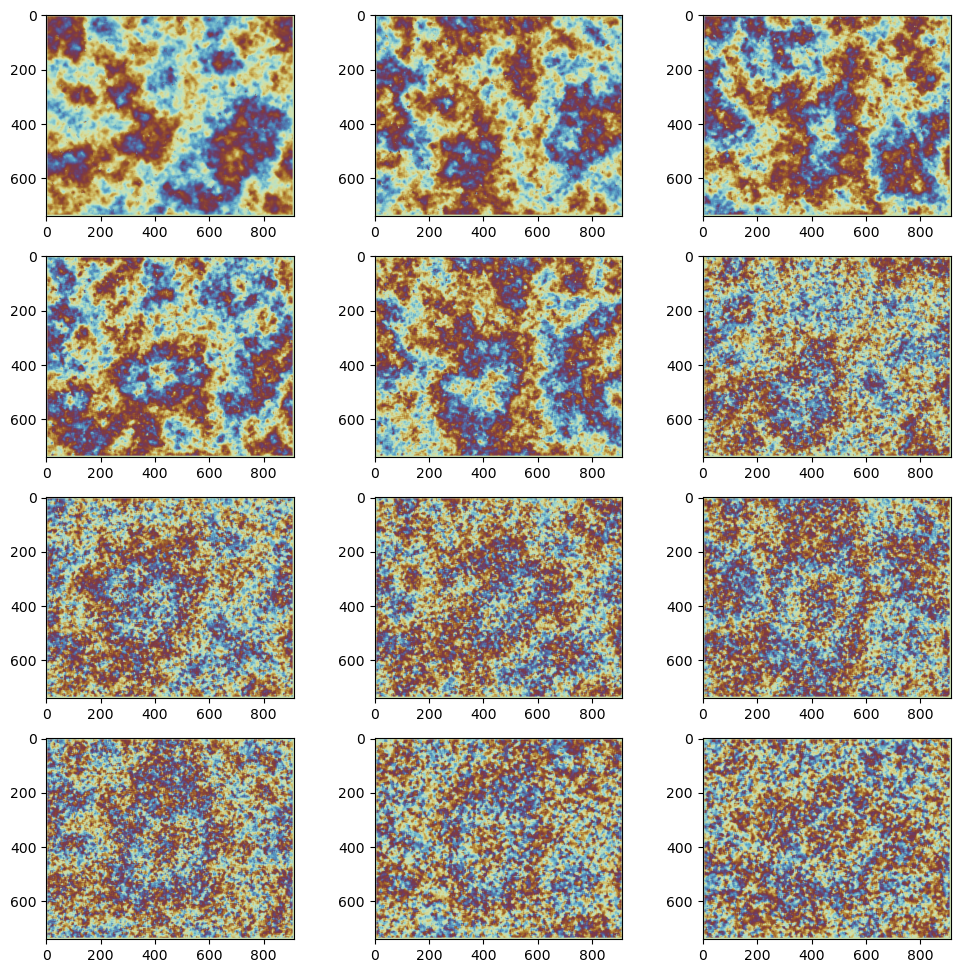

In [52]:
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(12, 12))
for ax, fname in zip(axes.ravel(), ifg_files[::3]):
    ax.imshow(np.angle(io.load_gdal(fname)), cmap='cmc.romaO')

We see that even after over 30 images, our interferograms result still have a coherent phases.